In [510]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
plt.rcParams['figure.figsize'] = [15, 8]
import seaborn as sns
sns.set(context='paper', style='darkgrid', rc={'figure.facecolor':'white'}, font_scale=2.0)

In [511]:
# Implementation for my knn
def l2NormAvgOutput(xTestInstance, xtrain, ytrain, k):
    # This is just to protect the method from running for K=0, ideally should be handled as error.
    if k == 0:
        return 0
    dist = (xtrain - xTestInstance)**2
    dist = np.sum(dist, axis=1)
    dist = np.sqrt(dist)
    return np.mean(ytrain[np.argpartition(dist, k)[:k]])

def myknn(xtest, xtrain, ytrain, k):
    return np.apply_along_axis(l2NormAvgOutput, 1, xtest, xtrain, ytrain, k)

In [512]:
def generateObservations(numOfIndependentVar=5, mean=np.array([1, 2, 3, 4, 5]), totalNumOfObservations=1000):
    cov = np.full(shape=[numOfIndependentVar, numOfIndependentVar], fill_value=1.0, dtype=float)
    M,N = cov.shape
    X, Y = np.ix_(np.arange(M), np.arange(N))
    out = cov * (0.5 ** abs(X - Y))
    #Setting seed as 1
    np.random.seed(1)
    rv = multivariate_normal.rvs(mean=mean, cov=out, size=totalNumOfObservations)
    mu, sigma = 0, 1 # mean and standard deviation
    epsilon = np.random.normal(mu, sigma, 1000)
    y = rv[:, 0] + rv[:, 1] + ((rv[:, 2] - 2.5) ** 2) + epsilon
    ddf = pd.DataFrame(data=rv, columns=['X1', 'X2', 'X3', 'X4', 'X5'])
    ddf['Y'] = y
    print(ddf.iloc[:3])
#     print(rv[0:3, :], y[0:3])
    return rv, y

def generateTestTrainData(X, Y, trainingSetSize=400):
    xtrain = X[:trainingSetSize, :]
    ytrain = Y[:trainingSetSize]
    xtest = X[trainingSetSize:, :]
    ytest = Y[trainingSetSize:]
    return xtrain, ytrain, xtest, ytest


def generateYforBasicLinearModel(X):
    return X[:, 0] + X[:, 1] + X[:, 2] + X[:, 3] + X[:, 4]

         X1        X2        X3        X4        X5          Y
0 -0.206456  0.625077  1.775050  2.406915  5.181349   0.019418
1  3.740236  4.405034  4.350167  4.961146  5.395203  12.697279
2 -0.869265 -0.281322  2.102837  3.417965  5.903901  -2.121640
K=5, MeanSquaredError=1.555822
Linear model MSE: 2.424736


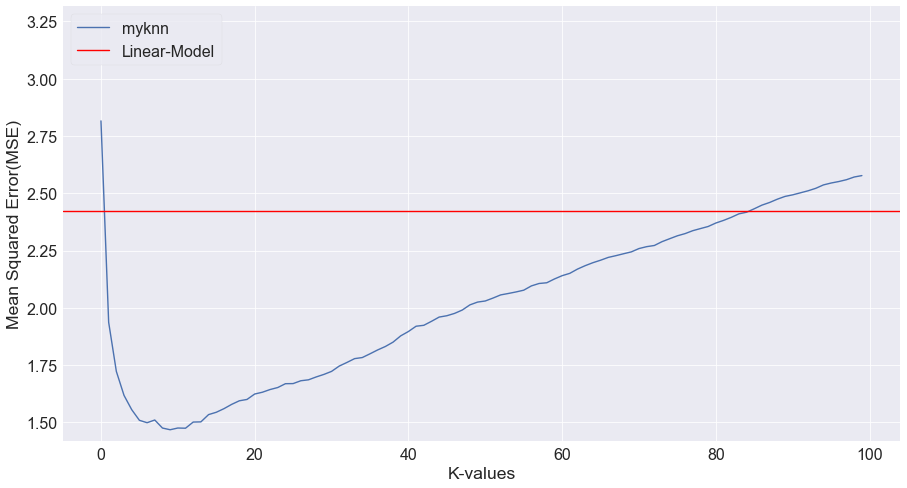

In [513]:
errors = []
X, Y = generateObservations()
xtrain, ytrain, xtest, ytest = generateTestTrainData(X, Y)

# k = 5
yhat = myknn(xtest, xtrain, ytrain, 5)
error = np.sum((ytest-yhat) ** 2)/len(ytest)
print("K=%d, MeanSquaredError=%f"%(5, error))

# print(len(ytest))
for k in range(101):
    yhat = myknn(xtest, xtrain, ytrain, k)
    error = np.sum((ytest-yhat) ** 2)/len(ytest)
    errors.append(error)

# print("Errors ", errors)
# Sklean-linear regression
lm = LinearRegression().fit(xtrain, ytrain)
yhat = lm.predict(xtest)
lm_error = np.sum((ytest-yhat) ** 2)/len(ytest)
print("Linear model MSE: %f" % lm_error)

#Basic linear model
yhat = generateYforBasicLinearModel(xtest)
blm_error = np.sum((ytest-yhat) ** 2) / len(ytest)
# print("BasicLinearModel MSE: %f" % blm_error)

plt.plot(errors[1:], label='myknn')
plt.axhline(y=lm_error, color='r', label='Linear-Model')
plt.legend(loc='upper left', frameon=True, fancybox=True)
plt.xlabel("K-values")
plt.ylabel("Mean Squared Error(MSE)")
plt.ylim(np.min(errors[1:]) - 0.05, np.max(errors[1:]) + 0.5)
plt.show()

Beta:  [-0.03234809  0.03021324 -0.0978601   0.11813833  0.01098584  0.07136175
 -0.19961831  0.28729784  0.00752068 -0.32105484  0.28984483 -0.23540706
 -0.20675364  0.09123043 -0.41793609]
Coeff:  [-0.03231644  0.03024509 -0.09793597  0.1182731   0.01139038  0.07131225
 -0.19970377  0.28723281  0.00756485 -0.32103934  0.29085076 -0.23652616
 -0.20680497  0.09123541 -0.41797282]


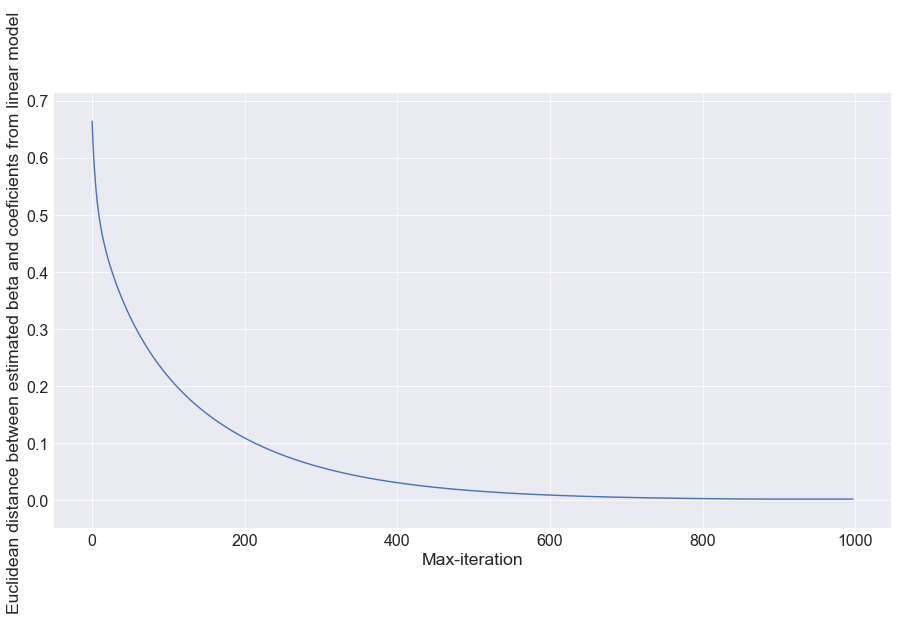

In [514]:
def mylm_g(X, Y, maxitr, delta=0.1, epsilon=10e-6):
    m = len(Y)
    beta = np.zeros([X.shape[1],])
    for i in range(maxitr):
#         print("Running iteration %d" % i)
        preds = X.dot(beta)
        error = preds - Y
        gradient = X.T.dot(error) / X.shape[0]
        betaNew = beta - delta * gradient
        dis = np.linalg.norm(betaNew - beta)
        beta = betaNew
        if dis < epsilon:
            break
#     print("Beta: ", beta)
    return beta

def getData():
    url = 'https://maya-jha.github.io/data/BostonData.csv'
    df = pd.read_csv(url, index_col=0)
    df = df.drop(columns=['town', 'tract', 'medv'])
    df.head()
    Y = df['cmedv'].values
    X = df.loc[:, df.columns != 'cmedv'].values
    X_scaled = preprocessing.scale(X)
    Y_scaled = preprocessing.scale(Y)
    return X_scaled, Y_scaled

X, Y = getData()
maxIter=1000
beta_gs = []
for itr in range(1, maxIter):
    beta_g = mylm_g(X, Y, itr)
    beta_gs.append(beta_g)
beta_gs = np.array(beta_gs)

# Linear model
print("Beta: ", beta_gs[871])
lm = LinearRegression(fit_intercept=False).fit(X, Y)
print("Coeff: " , lm.coef_)

def distance(X, Y):
    return np.linalg.norm(X - Y)
    
dt = np.apply_along_axis(distance, 1, beta_gs, lm.coef_)
plt.plot(dt[1:])
plt.xlabel("Max-iteration")
plt.ylabel("Euclidean distance between estimated beta and coeficients from linear model ")
plt.ylim(np.min(dt[1:]) - 0.05, np.max(dt[1:]) + 0.05)
plt.show()

In [515]:
url = 'https://maya-jha.github.io/data/BostonData.csv'
df = pd.read_csv(url, index_col=0)
df = df.drop(columns=['town', 'tract', 'medv'])
df.head()
df_new = df.loc[:, df.columns != 'cmedv']
df_new['cmedv'] = df['cmedv']
Y = df['cmedv'].values
X = df.loc[:, df.columns != 'cmedv'].values
all_data = df_new.values
lm = LinearRegression().fit(X, Y)
print("Non scaled linear model beta: ", lm.coef_)

# Taking the best beta from previous run
scaled_beta = beta_gs[871]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(all_data)
std = scaler.scale_[0:15]
transformed_beta = (scaled_beta * scaler.scale_[15]) / std
print("Transformed beta: ", transformed_beta)
print("Distance from non-scaled linear model: ", np.linalg.norm(transformed_beta - lm.coef_))

Non scaled linear model beta:  [-3.93520158e+00  4.49544140e+00 -1.04546949e-01  4.65647582e-02
  1.52453460e-02  2.57801975e+00 -1.58245766e+01  3.75371170e+00
  2.46765932e-03 -1.39992664e+00  3.06714509e-01 -1.28863292e-02
 -8.77121177e-01  9.17619603e-03 -5.37441098e-01]
Transformed beta:  [-3.93905529e+00  4.49070794e+00 -1.04465953e-01  4.65116982e-02
  1.47038993e-02  2.57980927e+00 -1.58178049e+01  3.75456150e+00
  2.45325148e-03 -1.39999423e+00  3.05653719e-01 -1.28253592e-02
 -8.76903477e-01  9.17569567e-03 -5.37393870e-01]
Distance from non-scaled linear model:  0.009408646643228293
